# ANATOMY OF A NEURAL NETWORK
![title](./pics/neural-net.png)

In [17]:
# imports

# keras imports
from keras import layers
from keras import models
from keras import optimizers
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical


# general imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown #just to display markdown

## AUTOMATIC SHAPE INFERENCE 
 
The layers that you add to keras models are dynamically built to match the shape of the incoming layer.

In [18]:
display(Markdown("#### After first layers' {None,32} dimension(None stands for number of examples in batch), the input shape of next layer is automatically interpreted")) 
# A dense layer with 6 output units
model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(6))
model.summary()

#### After first layers' {None,32} dimension(None stands for number of examples in batch), the input shape of next layer is automatically interpreted

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 198       
Total params: 25,318
Trainable params: 25,318
Non-trainable params: 0
_________________________________________________________________


#### In Keras models can be developed either by using Sequential model or Functional API's

Lets build model below using both the metheodologies
![title](./pics/model-architecture.png)


## A network definition using the Sequential model

In [19]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


## A network definition using the functional API

In [20]:
input_tensor = layers.Input(shape=(10000,))
x = layers.Dense(16, activation='relu')(input_tensor)
x = layers.Dense(16, activation='relu')(x)
output_tensor = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(input_tensor, output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


## Defining a loss function and an optimizer

In [21]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Data preparation

IMDB data encoding from text will be extensively covered in "text_pre-processing_basic model_building" 

In [22]:
# pre-processing initializations
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

# data pre-prcessing
### IMDB data encoding from text will be extensively covered in "text_pre-processing_basic model_building" ##

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print ("before data preprocessing")
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape, "\n")

print("\nImdb review 1 sample input data\n")
print(input_train[:1]) 

print("\nImdb review data lables")
print(y_train[:2])
print(
"""
Note:  
0 : "Negative review"
1 : "Positive review"
post_padding in input data helps gragient in LSTM flow better 

"""
)

Loading data...
before data preprocessing
input_train shape: (25000,)
input_test shape: (25000,) 


Imdb review 1 sample input data

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38

### There are two ways we could do that:

- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).

- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

#### We will go with the latter solution

## Encoding the integer sequences into a binary matrix

In [23]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(input_train)

# Our vectorized test data
x_test = vectorize_sequences(input_test)

# Our vectorized labels
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

print("\n Sample input data after encoding\n")
print(x_train[:1]) 

print("\nImdb review data lables after encoding")
print(x_test[:2])


 Sample input data after encoding

[[0. 1. 1. ... 0. 0. 0.]]

Imdb review data lables after encoding
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


## Setting aside a validation set

In [24]:
x_val = x_train[:10000]
y_val = y_train[:10000]

partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

## Training our model

In [10]:
 history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 105us/step - loss: 0.5049 - acc: 0.7873 - val_loss: 0.3723 - val_acc: 0.8739
Epoch 2/20
15000/15000 [==============================] - 1s 87us/step - loss: 0.2932 - acc: 0.9046 - val_loss: 0.3007 - val_acc: 0.8864
Epoch 3/20
15000/15000 [==============================] - 1s 88us/step - loss: 0.2131 - acc: 0.9299 - val_loss: 0.2818 - val_acc: 0.8880
Epoch 4/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.1694 - acc: 0.9447 - val_loss: 0.2813 - val_acc: 0.8859
Epoch 5/20
15000/15000 [==============================] - 1s 86us/step - loss: 0.1352 - acc: 0.9565 - val_loss: 0.2867 - val_acc: 0.8841
Epoch 6/20
15000/15000 [==============================] - 1s 87us/step - loss: 0.1132 - acc: 0.9645 - val_loss: 0.3042 - val_acc: 0.8860
Epoch 7/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.0935 - acc: 0.9729 - val_loss: 0.3199 - val_ac

## Plotting the training and validation loss & accuracy from model training history

Values captured in history: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


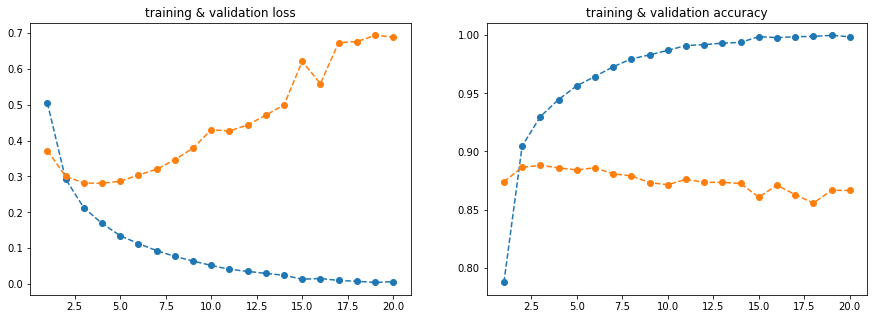

In [13]:
history_dict = history.history
print ("Values captured in history: {}".format(history_dict.keys()))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


# visualize model training
epochs = range(1, len(acc) + 1)
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(epochs, loss, '--o', label='Training loss')
axs[0].plot(epochs, val_loss, '--o', label='Validation loss')
axs[0].set_title('training & validation loss')
axs[1].plot(epochs, acc, '--o', label='Training acc')
axs[1].plot(epochs, val_acc, '--o', label='Validation acc')
axs[1].set_title('training & validation accuracy')
plt.show()
plt.close() 

## Generating predictions for new data

In [14]:
model.predict(x_test)

array([[0.00581402],
       [1.        ],
       [0.990448  ],
       ...,
       [0.00429063],
       [0.01205759],
       [0.51759356]], dtype=float32)